# Figure 4

In [1]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Setup.Read_HIV_Data import *

importing IPython notebook from Setup/Read_HIV_Data

In [3]:
import Setup.DX_Imports as dx

importing IPython notebook from Setup/DX_Imports

Set of patients used in analysis of age advancement

In [4]:
import Parallel.Age_HIV_Features as fx

importing IPython notebook from Parallel/Age_HIV_Features

importing IPython notebook from HIV_Age_Advancement

importing IPython notebook from Setup/MethylationAgeModels

In [5]:
sns.set_context("paper", rc={"lines.linewidth": 2.5, 
                             "font_size":14})
sns.set_style("white")

### Compile HIV and age associated markers 

Here I'm splitting them by direction as well, either up-regulated, down-regulated or neutral. Up-regulated means that a marker increases in methylation with the presence of HIV or increasing age. 

In [7]:
direction = fx.r4.multi_variate.HIV > 0
direction.name = 'up'
h = fx.g_hiv
h.name = 'HIV'
hiv_d = combine(h, direction)
hiv_d = hiv_d.replace({'both':'HIV-up', 
                       'up': 'neutral',
                       'neither': 'neutral',
                       'HIV': 'HIV-down'})
hiv_d.value_counts()

neutral     391683
HIV-down     46220
HIV-up       35141
dtype: int64

In [8]:
direction = fx.res.in_set_s1.multi_variate.age > 0
direction.name = 'up'
h = fx.g_age
h.name = 'age'
age_d = combine(h, direction)
age_d = age_d.replace({'both':'age-up', 
                       'up': 'neutral',
                       'neither': 'neutral',
                       'age': 'age-down'})
age_d.value_counts()

neutral     446117
age-down     13840
age-up       13087
dtype: int64

#### Looking at the assocation of age and HIV associated probes with genetic features

In [12]:
features = {'HIV-up': (hiv_d=='HIV-up') & (age_d != 'age-up'), 
            'HIV-down': (hiv_d=='HIV-down') & (age_d != 'age-down'),
            'age-up': (age_d=='age-up') & (hiv_d != 'HIV-up'), 
            'age-down': (age_d=='age-down') & (hiv_d != 'HIV-down'),
            'both-up': (hiv_d=='HIV-up') & (age_d=='age-up'),
            'both-down': (hiv_d=='HIV-down') & (age_d=='age-down')}

probes_sets = {'PRC2': dx.prc2_probes, 'CpG island': dx.cpg_island,
               'DHS': dx.dhs_site, 'Enhancer': dx.enhancer,
               'Gene body': dx.gene_body, 'TSS': dx.gene_tss,
               'Promoter': dx.promoter}

In [10]:
c1 = pd.DataFrame({i:v.value_counts() for i,v in features.iteritems()}).T
c1

,False,True
HIV-down,428593,44451
HIV-up,440472,32572
age-down,460973,12071
age-up,462526,10518
both-down,471275,1769
both-up,470475,2569


In [11]:
c2 = pd.DataFrame({i:v.value_counts() for i,v in probes_sets.iteritems()}).T
c2

,False,True
CpG island,314588,130023
DHS,425596,59916
Enhancer,382953,102559
Gene body,309941,175571
PRC2,406430,79082
Promoter,387422,98090
TSS,345509,140003


#### Looking at the overlap of age and HIV associated probes 

In [13]:
def odds_ratio(a,b):
    ct = pd.crosstab(a,b).astype(float)
    r = (ct.ix[0,0] * ct.ix[1,1]) / (ct.ix[0,1] * ct.ix[1,0])
    return r

In [14]:
ct = pd.crosstab(hiv_d, age_d).ix[['HIV-down','neutral','HIV-up'],
                                  ['age-down','neutral','age-up']]

or_ct = pd.DataFrame({a:{b:odds_ratio(hiv_d==a, age_d==b) for b in age_d.unique()}
                      for a in hiv_d.unique()}).T.ix[ct.index, ct.columns]
or_ct.columns.name = None
or_ct.index.name = None

In [15]:
or_ct

,age-down,neutral,age-up
HIV-down,1.37,1.24,0.29
neutral,0.87,1.29,0.70
HIV-up,0.84,0.52,3.20


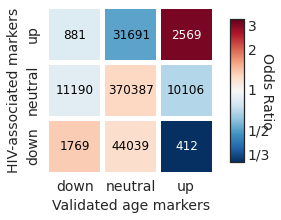

In [16]:
def overlap_plot(fig, ax):

    sns.heatmap(np.log2(or_ct).ix[::-1], linewidths=4, cbar=False, ax=ax, square=True,
                     center=0)
    ax.set_xticklabels([c.get_text().split('-')[-1]
                        for c in ax.get_xticklabels()], size=14)
    ax.set_yticklabels([c.get_text().split('-')[-1]
                        for c in ax.get_yticklabels()], size=14)
    ax.set_xlabel('Validated age markers', size=14, ha='center')
    ax.set_ylabel('HIV-associated markers\n', size=14, va='center')


    cbar = fig.colorbar(ax.get_children()[2], ticks=[-1.58,-1,0,1,1.58],
                        ax=ax, use_gridspec=True, pad=.05, aspect=10, shrink=.85)
    cbar.ax.set_yticklabels(['1/3','1/2',1,2,3], size=14)
    cbar.ax.set_ylabel('Odds Ratio', rotation=270, size=14)
    for i,(a,v) in enumerate(ct.iterrows()):
        for j,(b,c) in enumerate(v.iteritems()): 
            if np.log2(or_ct).abs().ix[a,b] > 1:
                color = 'white'
            else:
                color = 'black'
            ax.annotate(c, (j+.5, i+.5), ha='center', va='center', fontsize=12,
                        color=color)
            
fig, ax = subplots(figsize=(5.5,3))
overlap_plot(fig, ax)

#### Overlap of different combinations of age and HIV assoicated probes with genetic features

In [32]:
associations = {}
for i,a in features.iteritems():
    for j,b in probes_sets.iteritems():
        associations[(i,j)] = odds_ratio(a,b.ix[fx.probe_idx])
associations = pd.Series(associations)

In [33]:
associations.unstack()

,CpG island,DHS,Enhancer,Gene body,PRC2,Promoter,TSS
HIV-down,0.57,0.69,0.74,1.09,0.41,0.76,0.74
HIV-up,2.75,1.45,0.74,0.75,1.57,1.91,1.56
age-down,1.06,1.09,0.96,0.95,0.93,1.42,1.25
age-up,1.56,2.89,1.39,0.72,6.01,0.32,1.11
both-down,4.00,1.13,0.56,0.75,1.02,3.28,2.00
both-up,6.09,4.20,0.95,0.52,11.52,0.17,1.28


In [37]:
o = ['DHS','PRC2','CpG island','Enhancer', 'TSS','Gene body','Promoter']
p = ['HIV-up','both-up', 'age-up']
df1 = associations.unstack().T.ix[o[::-1],p]

o = ['DHS','PRC2','CpG island','Enhancer', 'TSS','Gene body','Promoter']
p = ['HIV-down','both-down', 'age-down']
df2 = associations.unstack().T.ix[o[::-1],p]

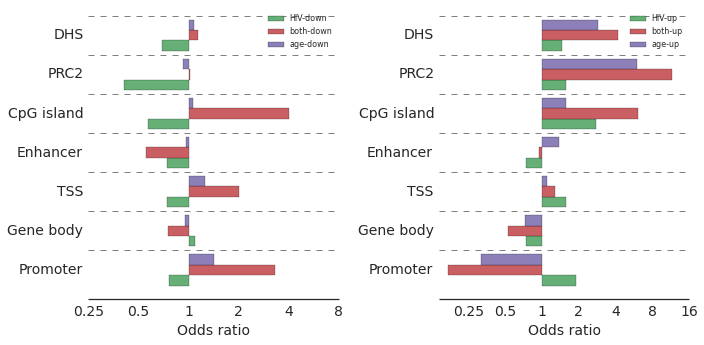

In [77]:
cc = sns.color_palette()
def enrichment_plot(df, ax):
    np.log2(df).plot(kind='barh', ax=ax, alpha=.9, width=.8, 
                                   color=[cc[1],  cc[2], cc[3]])
    ax.set_xticks([-3, -2,-1,0,1,2,3,4])
    ax.set_xticklabels([.125, .25,.5,1,2,4,8,16], size=14)
    ax.set_ylim(-.75, 6.72)
    ax.set_xlabel('Odds ratio', size=14)
    ax.legend().set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticklabels([c.get_text().replace('-','\n')
                    for c in ax.get_yticklabels()], size=14)
    for i in range(len(o)):
        ax.axhline(i+.5, color='grey', ls='--', lw=1)
    ax.legend()
    prettify_ax(ax, top=False)

fig, axs = subplots(1,2, figsize=(10,5))
enrichment_plot(df2, axs[0])
axs[0].set_xbound(-2, 3.)
enrichment_plot(df1, axs[1])
axs[1].set_xbound(-2.8, 4.)
fig.tight_layout()

#### Distrubution of CpG methylation levels among age and HIV associated probes

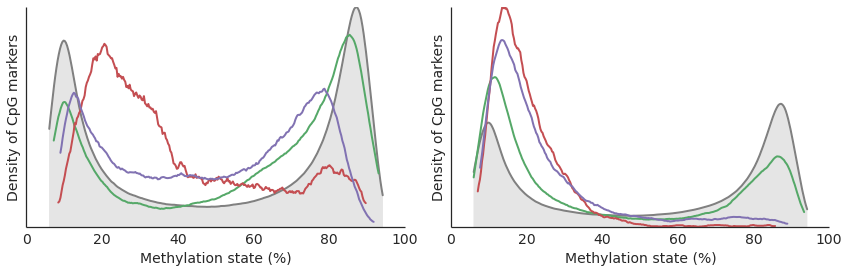

In [75]:
cc = sns.color_palette()[1:]
mm = fx.mm #mean methylation for control patients
def dist_plot_split(splits, ax):
    for i,split in enumerate(splits):
        draw_dist(mm.ix[ti(split)], ax=ax, colors=cc[i])

    d = smooth_dist(mm)
    ax.fill_between(d.index, 0, d, color='grey', alpha=.2)
    ax.plot(d.index, d, color='grey', lw=2, zorder=-1)
    ax.set_ylabel('Density of CpG markers', size=14)
    ax.set_yticks([])
    ax.set_xlabel('Methylation state (%)', size=14)
    ax.set_xticks([0, .2, .4, .6, .8, 1.])
    ax.set_xticklabels(['0', '20', '40', '60', '80', '100'],
                       size=14)
    #ax.set_ybound(0,7.2)
    ax.set_xbound(0,1)
    prettify_ax(ax)

fig, axs = subplots(1,2, figsize=(12,4))
dist_plot_split([features['HIV-down'],features['both-down'],features['age-down']],
                axs[0])
dist_plot_split([features['HIV-up'],features['both-up'],features['age-up']],
                axs[1])
fig.tight_layout()

#### Compiling the final figure

In [29]:
import matplotlib.gridspec as gridspec

In [30]:
rcParams['font.sans-serif'] = 'Arial'

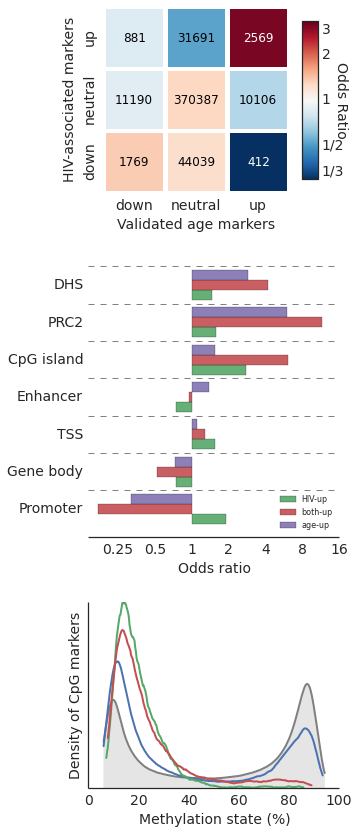

In [79]:
plt.figure(figsize=(4.5,14))
gs1 = gridspec.GridSpec(3, 1, height_ratios=[2,3,2], hspace=.3)

#gs1.update(left=0.05, right=0.48, wspace=0.05)

ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])
axs = [ax1, ax2, ax3]

overlap_plot(fig, ax1)
enrichment_plot(df1, axs[1])
axs[1].set_xbound(-2.8, 4.)
axs[1].legend(loc='lower right')

dist_plot_split([features['HIV-up'],features['both-up'],features['age-up']],
                axs[2])

plt.savefig(FIGDIR + 'fig3_ab_c.pdf')